In [1]:
## sleep stage classification - 2 class - using SAX features
## PAA time window = 0.1s

## increase from dimer to trimer? change alphabet size? 


# http://localhost:8888/notebooks/Intern/Sleep_stage_Classification_2Class-imbalanced-data-SMOTE.ipynb
# http://localhost:8888/notebooks/GPU_run/EEG_Classification_CNN_full_SMOTE_diff_network_GPU.ipynb
# http://localhost:8888/notebooks/classification_2class_epochData_newPkl.ipynb

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import precision_recall_fscore_support

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [4]:
## load data ##

file_location='C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018'
os.chdir('C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') #'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('Frac_sax_dimer_0.1s_rm_1st_wake.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.093960,0.043624,0.026846,0.003356,0.046980,0.117450,0.107383,0.026846,0.026846,0.104027,0.134228,0.070470,0.003356,0.033557,0.067114,0.093960,400,1,s2e1,wake
1,0.080537,0.023490,0.000000,0.000000,0.020134,0.288591,0.097315,0.003356,0.003356,0.093960,0.218121,0.030201,0.000000,0.000000,0.033557,0.107383,400,1,s3e1,wake
2,0.120805,0.023490,0.000000,0.000000,0.020134,0.244966,0.083893,0.000000,0.003356,0.077181,0.278523,0.016779,0.000000,0.000000,0.016779,0.114094,400,1,s4e1,wake
3,0.163880,0.053512,0.023411,0.003344,0.066890,0.163880,0.033445,0.016722,0.013378,0.053512,0.096990,0.066890,0.000000,0.010033,0.076923,0.157191,400,1,s5e1,wake
4,0.120401,0.036789,0.033445,0.020067,0.053512,0.140468,0.036789,0.013378,0.036789,0.063545,0.197324,0.040134,0.000000,0.006689,0.066890,0.133779,400,1,s5e2,wake


In [5]:
### check the data ###
# 1. look for null values
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58169 entries, 0 to 58168
Data columns (total 20 columns):
0              58169 non-null float64
1              58169 non-null float64
2              58169 non-null float64
3              58169 non-null float64
4              58169 non-null float64
5              58169 non-null float64
6              58169 non-null float64
7              58169 non-null float64
8              58169 non-null float64
9              58169 non-null float64
10             58169 non-null float64
11             58169 non-null float64
12             58169 non-null float64
13             58169 non-null float64
14             58169 non-null float64
15             58169 non-null float64
pID            58169 non-null object
day            58169 non-null object
epoch          58169 non-null object
class_label    58169 non-null object
dtypes: float64(16), object(4)
memory usage: 8.9+ MB


In [6]:
dfull.isnull().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
pID            0
day            0
epoch          0
class_label    0
dtype: int64

In [7]:
# 2. check data distribution
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             37566
dtype: int64

In [8]:
dfull.groupby(['pID','class_label']).size()

pID  class_label  
400  sleep_stage_1     117
     sleep_stage_2     623
     wake             1992
401  sleep_stage_1     201
     sleep_stage_2    1222
     wake             2319
402  sleep_stage_1     278
     sleep_stage_2     947
     wake             2292
403  sleep_stage_1     106
     sleep_stage_2     885
     wake             2173
404  sleep_stage_1     303
     sleep_stage_2    1134
     wake             1421
405  sleep_stage_1     158
     sleep_stage_2     833
     wake             1668
406  sleep_stage_1     146
     sleep_stage_2     824
     wake             2294
407  sleep_stage_1     173
     sleep_stage_2     795
     wake             2289
408  sleep_stage_1     107
     sleep_stage_2     591
     wake             2061
409  sleep_stage_1     100
     sleep_stage_2    1073
     wake             1116
410  sleep_stage_1     182
     sleep_stage_2    1278
     wake             2037
411  sleep_stage_1      31
     sleep_stage_2     898
     wake             1813
412  slee

In [9]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'

In [ ]:
### create training & test sets ###

In [10]:
### by patient ID  ###
ID = dfull['pID'].unique() # create ID list

np.random.seed(456)   ## select the IDs for the 2 sets
msk = np.random.rand(len(ID)) < 0.8
trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
trainIDs['pID'] = ID[msk]
testIDs['pID'] = ID[~msk]
print(trainIDs['pID'].tolist())
print(testIDs['pID'].tolist())


Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #
print(Train.shape)
print(Test.shape)
## also, check the distribution of class 0 & 1 in the train & test sets
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())


X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()  ## create X & y splits
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train1 = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()
X_train1 = X_train1.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train1 = y_train1.drop(['index'],1)
y_test = y_test.drop(['index'],1)

['400', '401', '402', '404', '405', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419']
['403', '406']
(51741, 21)
(6428, 21)
Train distribution
class2
0    33099
1    18642
dtype: int64

Test distribution
class2
0    4467
1    1961
dtype: int64


In [ ]:
'''
### by random sampling ###
X =  dfull.drop(['pID','day','epoch','class_label','class2'], 1) # dfull[['delta','theta','alpha','beta','gamma']]
y =  dfull['class2'] 

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  #stratify=y) #stratify=True

# to test if split is stratified
y_tr = pd.DataFrame(y_train1)
y_ts = pd.DataFrame(y_test)
print('')
print(y_tr.groupby('class2').size())
print('')
print(y_ts.groupby('class2').size())
'''

In [ ]:
'''
## upsample training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)
'''

In [ ]:
'''
check_upsample = pd.DataFrame(y_train)
check_upsample.columns = ['class2']
#check_upsample.head(2)
print(check_upsample.groupby('class2').size())'''

In [11]:
### data scaling ###
from sklearn.preprocessing import StandardScaler  #, MinMaxScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers 
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [12]:
### SVC model ###
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-04-04 20:22:43


In [13]:
model_svc = SVC()
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-04-04 20:23:51'

In [15]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

Confusion matrix, without normalization
[[4098  369]
 [ 271 1690]]
Normalized confusion matrix
[[0.92 0.08]
 [0.14 0.86]]


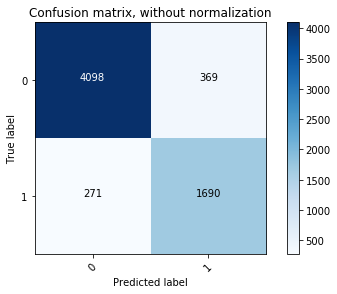

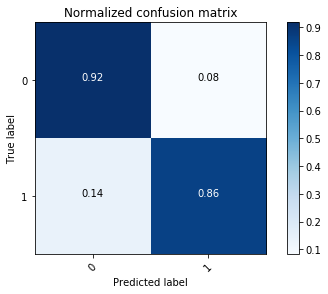

In [16]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [17]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4467
           1       0.82      0.86      0.84      1961

   micro avg       0.90      0.90      0.90      6428
   macro avg       0.88      0.89      0.88      6428
weighted avg       0.90      0.90      0.90      6428



In [18]:
print(accuracy_score(y_test,y_pred))

0.9004355942750467


In [19]:
#from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.94, 0.82]),
 array([0.92, 0.86]),
 array([0.93, 0.84]),
 array([4467, 1961], dtype=int64))

In [20]:
p = precision_recall_fscore_support(y_test,y_pred) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.8618052014278429 , spec: 0.9173942243116185


In [21]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-04-04 20:23:55


In [22]:
model_svc2 = SVC(class_weight='balanced')
model_svc2.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-04-04 20:25:30


In [24]:
# predict on test data - check metrics
y_pred = model_svc2.predict(X_test_scaled)

Confusion matrix, without normalization
[[3843  624]
 [ 116 1845]]
Normalized confusion matrix
[[0.86 0.14]
 [0.06 0.94]]


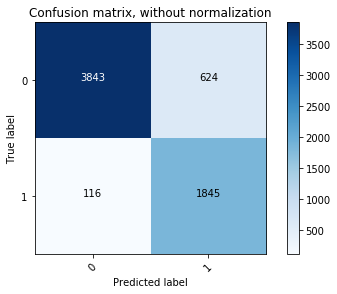

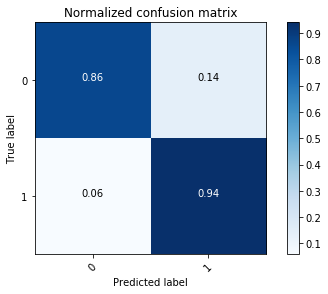

In [25]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [26]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      4467
           1       0.75      0.94      0.83      1961

   micro avg       0.88      0.88      0.88      6428
   macro avg       0.86      0.90      0.87      6428
weighted avg       0.90      0.88      0.89      6428



In [27]:
print(accuracy_score(y_test,y_pred))

0.8848786558805227


In [28]:
#from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.97, 0.75]),
 array([0.86, 0.94]),
 array([0.91, 0.83]),
 array([4467, 1961], dtype=int64))

In [29]:
p = precision_recall_fscore_support(y_test,y_pred) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.9408465068842428 , spec: 0.8603089321692411


In [ ]:
###############  NOT CHECKED AFTER THIS ###############

In [ ]:
## plotted 16 PCs, checked with top 6 PCs - sensitivity reduces even more

from sklearn import decomposition
pca = decomposition.PCA(n_components = 16)  # n_components = N; should be <= #features
pca.fit(X_train1)
X_train_pca = pca.transform(X_train1)
print(pca.explained_variance_ratio_)

In [ ]:
pca_var = pca.explained_variance_ratio_ 
indices = np.argsort(pca_var)[::-1]
# Plot the PC variances
plt.figure()
plt.title("PCA variances")
plt.bar(range(X_train_pca.shape[1]), pca_var[indices],
       color="r", align="center")
plt.xticks(range(X_train_pca.shape[1]), indices)
plt.xlim([-1, X_train_pca.shape[1]])
plt.show()

In [ ]:
pca = decomposition.PCA(n_components = 6)  # n_components = N; should be <= #features
pca.fit(X_train1)
X_train_pca = pca.transform(X_train1)

X_test_pca = pca.transform(X_test)

In [ ]:
model_svc_pca = SVC()
model_svc_pca.fit(X_train_pca, y_train1)

In [ ]:
# predict on test data - check metrics
y_pred_pca = model_svc_pca.predict(X_test_pca)

In [ ]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_pca)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
############## not checked beyond this #############

In [ ]:
#### model parameters changed ####

In [ ]:
model_svc2 = SVC(C=5, gamma=1)
model_svc2.fit(X_train_scaled, y_train1)

In [ ]:
# predict on test data - check metrics
y_pred2 = model_svc2.predict(X_test_scaled)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()